<a href="https://colab.research.google.com/github/FindPrint/Multiple-studies/blob/main/seaice_ou_compare_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/FindPrint/Multiple-studies.git
%cd Multiple-studies


Cloning into 'Multiple-studies'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 45 (delta 12), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (45/45), 22.92 KiB | 7.64 MiB/s, done.
Resolving deltas: 100% (12/12), done.
/content/Multiple-studies


In [2]:
!pip install seaborn


In [3]:
from google.colab import files

# Uploader ton script et ton CSV
uploaded = files.upload()


Saving N_09_extent_v4.0.csv to N_09_extent_v4.0 (1).csv


In [4]:
from google.colab import files

# Uploader ton script et ton CSV
uploaded = files.upload()


Saving seaice_ou_quadratic.py to seaice_ou_quadratic (1).py


In [5]:
!mkdir -p code data figures
!mv seaice_ou_quadratic.py code/
!mv N_09_extent_v4.0.csv data/


In [6]:
data = pd.read_csv("../data/N_09_extent_v4.0.csv")


NameError: name 'pd' is not defined

In [9]:
# 1. Importer les librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Charger ton fichier CSV
data = pd.read_csv("../data/N_09_extent_v4.0.csv")

# 3. Vérifier les premières lignes
print(data.head())


FileNotFoundError: [Errno 2] No such file or directory: '../data/N_09_extent_v4.0.csv'

In [8]:
data = pd.read_csv("data/N_09_extent_v4.0.csv")


In [10]:
import os
import pandas as pd
import urllib.request

# Nom du fichier attendu
filename = "N_09_extent_v4.0.csv"

# URL brute GitHub (⚠️ assure-toi que le fichier est bien poussé dans /data/ sur ton dépôt)
github_url = "https://raw.githubusercontent.com/FindPrint/Multiple-studies/main/data/N_09_extent_v4.0.csv"

# Vérifier si le fichier existe déjà localement
if not os.path.exists(filename):
    print("Fichier non trouvé localement. Téléchargement depuis GitHub...")
    urllib.request.urlretrieve(github_url, filename)
    print("Téléchargement terminé.")
else:
    print("Fichier trouvé localement.")

# Charger le CSV avec pandas
data = pd.read_csv(filename)

# Afficher les 5 premières lignes pour vérifier
print(data.head())


Fichier non trouvé localement. Téléchargement depuis GitHub...
Téléchargement terminé.
   year   mo  source_dataset   region   extent     area
0  1979    9      NSIDC-0051        N     7.05     4.58
1  1980    9      NSIDC-0051        N     7.67     4.87
2  1981    9      NSIDC-0051        N     7.14     4.44
3  1982    9      NSIDC-0051        N     7.30     4.43
4  1983    9      NSIDC-0051        N     7.39     4.70


In [11]:
!python code/seaice_ou_quadratic.py


Années de franchissement : [np.int32(2030), np.int32(2032), np.int32(2036), np.int32(2035), np.int32(2036), np.int32(2037), np.int32(2037), np.int32(2035), np.int32(2034), np.int32(2036), np.int32(2036), np.int32(2037), np.int32(2035), np.int32(2039), np.int32(2034), np.int32(2035), np.int32(2038), np.int32(2033), np.int32(2035), np.int32(2037)]
Année médiane : 2035
/content/Multiple-studies/code/seaice_ou_quadratic.py:121: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
Figure(1400x700)


In [12]:
# 📦 Imports nécessaires
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact, FloatSlider
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# 🔹 Charger les données NSIDC (septembre uniquement)
url = "https://raw.githubusercontent.com/FindPrint/Multiple-studies/main/data/N_09_extent_v4.0.csv"
data = pd.read_csv(url)
data.columns = data.columns.str.strip()
data = data[["year", "mo", "extent", "area"]].copy()
data["date"] = pd.to_datetime(dict(year=data["year"], month=data["mo"], day=1))

# 🔹 Normalisation par rapport à la climatologie 1981–2010
clim = data[(data["year"] >= 1981) & (data["year"] <= 2010)]["extent"].mean()
data["phi_star"] = data["extent"] / clim

# 🔹 Fonction interactive
@interact(
    gamma=FloatSlider(value=0.13, min=0.05, max=0.3, step=0.01, description="γ (rappel)"),
    D=FloatSlider(value=0.0002, min=0.00005, max=0.001, step=0.00005, description="D (bruit)")
)
def simulate_ou(gamma, D):
    # Paramètres du drift quadratique
    a, b, c = 1.1945, -0.000955, -0.000000033
    n_sims = 20
    n_steps = (2050 - 1979) * 12
    t = np.arange(n_steps)
    dates = pd.date_range("1979-01-01", periods=n_steps, freq="MS")
    mu_t = a + b * t + c * t**2

    # Simulations OU
    simulations, sim_sept, crossing_years = [], [], []
    for s in range(n_sims):
        phi = np.zeros(n_steps)
        phi[0] = 1.0
        for k in range(1, n_steps):
            phi[k] = phi[k-1] - gamma * (phi[k-1] - mu_t[k]) + np.sqrt(2*D) * np.random.randn()
        simulations.append(phi)

        sim_df = pd.DataFrame({"date": dates, "phi": phi})
        sim_df["month"] = sim_df["date"].dt.month
        sim_df["year"] = sim_df["date"].dt.year
        sept = sim_df[sim_df["month"] == 9].groupby("year")["phi"].mean()
        sim_sept.append(sept)
        below = sept[sept < 0.5]
        crossing_years.append(below.index[0] if not below.empty else None)

    valid_years = [y for y in crossing_years if y is not None]
    median_year = int(np.median(valid_years)) if valid_years else None

    # 🔹 Figure
    plt.figure(figsize=(14, 7))
    sept_obs = data[data["mo"] == 9]
    plt.scatter(sept_obs["date"], sept_obs["phi_star"], color="black", label="Observé (septembre)")

    for sept in sim_sept:
        plt.plot(sept.index, sept.values, alpha=0.4, color="steelblue")

    plt.axhline(1.0, color="red", linestyle="--", label="Climatologie")
    plt.axhline(0.5, color="orange", linestyle="--", label="Seuil critique 0.5")

    plt.title(f"Banquise Arctique — OU quadratique (γ={gamma}, D={D})")
    plt.xlabel("Année")
    plt.ylabel("φ*(t) en septembre")
    plt.legend()
    plt.grid(True)

    if valid_years:
        ax_inset = inset_axes(plt.gca(), width="35%", height="35%", loc="upper right")
        sns.histplot(valid_years, bins=range(min(valid_years), max(valid_years)+1),
                     ax=ax_inset, color="skyblue", edgecolor="black")
        ax_inset.axvline(median_year, color="red", linestyle="--", label=f"Médiane {median_year}")
        ax_inset.set_title("Distribution des franchissements")
        ax_inset.set_xlabel("Année")
        ax_inset.set_ylabel("Fréquence")
        ax_inset.legend()

    plt.tight_layout()
    plt.show()

    if median_year:
        print(f"Année médiane de franchissement : {median_year}")


interactive(children=(FloatSlider(value=0.13, description='γ (rappel)', max=0.3, min=0.05, step=0.01), FloatSl…

Années de franchissement stochastiques : [np.int32(2036), np.int32(2039), np.int32(2038), np.int32(2037), np.int32(2035), np.int32(2036), np.int32(2038), np.int32(2037), np.int32(2036), np.int32(2036), np.int32(2036), np.int32(2034), np.int32(2037), np.int32(2035), np.int32(2034), np.int32(2040), np.int32(2033), np.int32(2036), np.int32(2036), np.int32(2039)]
Année médiane : 2036


/tmp/ipython-input-1843997858.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


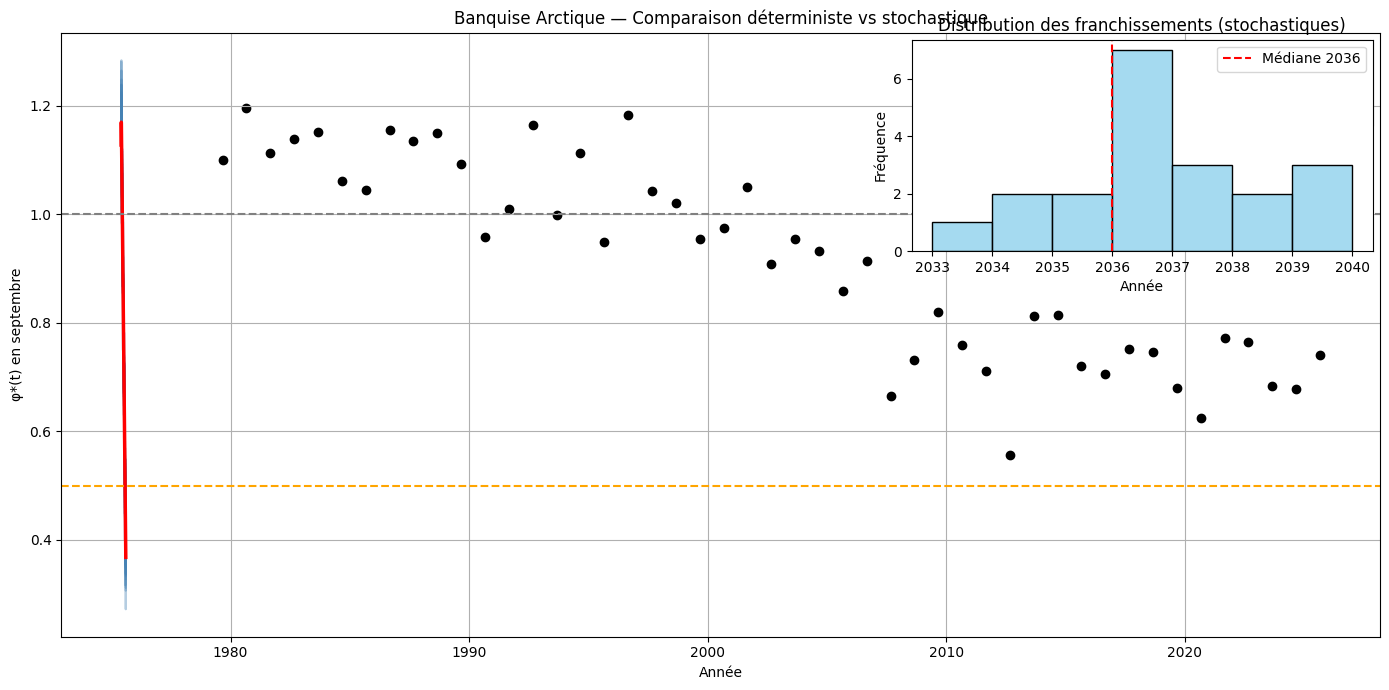

In [13]:
"""
Comparaison entre trajectoire déterministe (D=0) et stochastiques (D>0)
pour le déclin de la banquise arctique en septembre.

- Drift quadratique μ(t)
- Simulation OU avec et sans bruit
- Extraction des minima de septembre
- Calcul de l'année médiane de franchissement du seuil φ* < 0.5
- Figure de synthèse
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# -----------------------------
# 1. Charger les données NSIDC
# -----------------------------
url = "https://raw.githubusercontent.com/FindPrint/Multiple-studies/main/data/N_09_extent_v4.0.csv"
data = pd.read_csv(url)
data.columns = data.columns.str.strip()
data = data[["year", "mo", "extent"]].copy()
data["date"] = pd.to_datetime(dict(year=data["year"], month=data["mo"], day=1))

# Normalisation par rapport à la climatologie 1981–2010
clim = data[(data["year"] >= 1981) & (data["year"] <= 2010)]["extent"].mean()
data["phi_star"] = data["extent"] / clim

# -----------------------------
# 2. Paramètres du modèle OU
# -----------------------------
a, b, c = 1.1945, -0.000955, -0.000000033
gamma = 0.13
D_stoch = 0.0002   # bruit pour les trajectoires stochastiques
n_sims = 20

n_steps = (2050 - 1979) * 12
t = np.arange(n_steps)
dates = pd.date_range("1979-01-01", periods=n_steps, freq="MS")
mu_t = a + b * t + c * t**2

# -----------------------------
# 3. Simulation déterministe (D=0)
# -----------------------------
phi_det = np.zeros(n_steps)
phi_det[0] = 1.0
for k in range(1, n_steps):
    phi_det[k] = phi_det[k-1] - gamma * (phi_det[k-1] - mu_t[k])

det_df = pd.DataFrame({"date": dates, "phi": phi_det})
det_df["month"] = det_df["date"].dt.month
det_df["year"] = det_df["date"].dt.year
det_sept = det_df[det_df["month"] == 9].groupby("year")["phi"].mean()

# -----------------------------
# 4. Simulations stochastiques (D>0)
# -----------------------------
sim_sept, crossing_years = [], []
for s in range(n_sims):
    phi = np.zeros(n_steps)
    phi[0] = 1.0
    for k in range(1, n_steps):
        phi[k] = phi[k-1] - gamma * (phi[k-1] - mu_t[k]) + np.sqrt(2*D_stoch) * np.random.randn()
    sim_df = pd.DataFrame({"date": dates, "phi": phi})
    sim_df["month"] = sim_df["date"].dt.month
    sim_df["year"] = sim_df["date"].dt.year
    sept = sim_df[sim_df["month"] == 9].groupby("year")["phi"].mean()
    sim_sept.append(sept)
    below = sept[sept < 0.5]
    crossing_years.append(below.index[0] if not below.empty else None)

valid_years = [y for y in crossing_years if y is not None]
median_year = int(np.median(valid_years)) if valid_years else None

print("Années de franchissement stochastiques :", crossing_years)
print("Année médiane :", median_year)

# -----------------------------
# 5. Figure de synthèse
# -----------------------------
plt.figure(figsize=(14, 7))

# Observations
sept_obs = data[data["mo"] == 9]
plt.scatter(sept_obs["date"], sept_obs["phi_star"], color="black", label="Observé (septembre)")

# Trajectoires stochastiques
for sept in sim_sept:
    plt.plot(sept.index, sept.values, alpha=0.4, color="steelblue")

# Trajectoire déterministe
plt.plot(det_sept.index, det_sept.values, color="red", linewidth=2.5, label="Déterministe (D=0)")

# Seuils
plt.axhline(1.0, color="grey", linestyle="--", label="Climatologie")
plt.axhline(0.5, color="orange", linestyle="--", label="Seuil critique 0.5")

plt.title("Banquise Arctique — Comparaison déterministe vs stochastique")
plt.xlabel("Année")
plt.ylabel("φ*(t) en septembre")
plt.legend()
plt.grid(True)

# Inset : histogramme des franchissements stochastiques
if valid_years:
    ax_inset = inset_axes(plt.gca(), width="35%", height="35%", loc="upper right")
    sns.histplot(valid_years, bins=range(min(valid_years), max(valid_years)+1),
                 ax=ax_inset, color="skyblue", edgecolor="black")
    ax_inset.axvline(median_year, color="red", linestyle="--", label=f"Médiane {median_year}")
    ax_inset.set_title("Distribution des franchissements (stochastiques)")
    ax_inset.set_xlabel("Année")
    ax_inset.set_ylabel("Fréquence")
    ax_inset.legend()

plt.tight_layout()
plt.show()
